<a href="https://colab.research.google.com/github/zm-f21/My-Computer-Vision-Project/blob/Branch-5-Updated-Data/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Object Detection Using YOLO <b> </h1></center>

This tutorial is designed to provide a comprehensive understanding of how to use YOLO, a state-of-the-art method in computer vision, for detecting objects in images.

Object detection and classification is a key technology in many areas, such as automated vehicles, security, and even healthcare.

We will begin with the basics of preparing (pre processing) an image dataset, ensuring it is ready for effective model training.We will then explore how YOLO, a type of convolutional neural network, automatically extracts features from images to recognize different objects. Understanding this process is crucial for grasping how YOLO operates.

The core of this tutorial is focused on transfer learning using YOLO. We will teach you how to take a pre-trained YOLO model and adapt it to a new dataset. This technique is efficient and powerful, allowing us to harness the strengths of YOLO with less computational effort.

By the end of this tutorial, you will have hands-on experience with preparing data, implementing YOLO, and understanding the principles behind it. This tutorial aims to equip students with practical skills and knowledge in one of the most exciting fields in technology.

Since its inception, the YOLO family of object detection models has come a long way. YOLOv8 is the most recent addition to this famous anchor-based single-shot family of object detectors. It comes with a bunch of improvements which include state-of-the-art accuracy and speed.  In this article, we will be fine tuning the YOLOv8 object detection model on a real-world pothole detection dataset.

In the previous lecture, you were asked to make your own custom datasets for a project you want to work on. Today we will explore how to finetune YOLO on a certain dataset.  

Importing required Libraries

In [ ]:
# Resources:
# Yolo Classification Model: https://docs.ultralytics.com/tasks/classify/#val

In [4]:
# Only run the code below when you want to clear files:
# !rm -rf /content/*

In [1]:
import zipfile
import os

# Create a folder for the unzipped files
os.makedirs("/content/Styles_unzipped", exist_ok=True)

# Unzip the file into that folder
with zipfile.ZipFile("/content/Styles.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/Styles_unzipped")

# Verify contents
os.listdir("/content/Styles_unzipped")


['Styles']

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps
import os
import shutil
import os, random
from tqdm import tqdm

# #/
# base_dir = "/content/asset_styles"
# os.makedirs(base_dir, exist_ok=True)

# # Paths for train/val/test
# for split in ["train", "val", "test"]:
#     os.makedirs(os.path.join(base_dir, split), exist_ok=True)
#     /#


In [ ]:
# @title
# OLD CODE OCT 26:
# The Code Below is the same as the Code Above but it resizes large images to
# avoid bomb decrompression and to convert tranparent images into RGB
import os
import shutil
import random
from PIL import Image, ImageOps
from tqdm import tqdm

# --- CONFIG ---
source_dir = "/content/Styles_unzipped"   # parent folder
output_base = "/content/asset_styles_yolo"       # YOLO-ready dataset output
splits = {"train": 0.7, "val": 0.2, "test": 0.1}
augment = True  # enable data augmentation

# --- Step 1: Create split folders ---
for split in splits.keys():
    os.makedirs(os.path.join(output_base, split), exist_ok=True)

# --- Step 2: Loop through style folders (Cartoon Stylized, Pixel Art, Vector Art) ---
style_folders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

for style in style_folders:
    style_path = os.path.join(source_dir, style)
    label_name = style.replace(" ", "_")  # YOLO doesn’t like spaces in class names

    # Create subfolders for each split
    for split in splits.keys():
        os.makedirs(os.path.join(output_base, split, label_name), exist_ok=True)

    # Collect all image paths from all subfolders (Background, Characters, Object, UI, etc.)
    image_paths = []
    for root, _, files in os.walk(style_path):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, f))

    print(f"📂 Found {len(image_paths)} images for {label_name}")

    # Shuffle and split
    random.shuffle(image_paths)
    n = len(image_paths)
    train_end = int(splits["train"] * n)
    val_end = int((splits["train"] + splits["val"]) * n)

    split_data = {
        "train": image_paths[:train_end],
        "val": image_paths[train_end:val_end],
        "test": image_paths[val_end:]
    }

    # --- Step 3: Copy and augment images ---
    for split, imgs in split_data.items():
        dest_dir = os.path.join(output_base, split, label_name)
        for img_path in tqdm(imgs, desc=f"{label_name} → {split}"):
            try:
                with Image.open(img_path) as img:
                    # --- Fix transparency / color mode ---
                    if img.mode == "RGBA":
                        img = img.convert("RGB")

                    # --- Resize if image is very large ---
                    if max(img.size) > 2048:
                        img.thumbnail((2048, 2048))  # keeps aspect ratio

                    base_name = os.path.basename(img_path)
                    save_path = os.path.join(dest_dir, base_name)
                    img.save(save_path)

                    # --- Step 4: Data Augmentation (optional) ---
                    if augment and split == "train":
                        # Horizontal Flip
                        flipped = ImageOps.mirror(img)
                        flipped.save(os.path.join(dest_dir, "flip_" + base_name))

                        # Vertical Flip
                        flipped_v = ImageOps.flip(img)
                        flipped_v.save(os.path.join(dest_dir, "vflip_" + base_name))

                        # Small Rotation (-15 to +15 degrees)
                        angle = random.uniform(-15, 15)
                        rotated = img.rotate(angle, expand=True)
                        rotated.save(os.path.join(dest_dir, f"rot{int(angle)}_" + base_name))

            except Exception as e:
                print(f"⚠️ Skipping {img_path}: {e}")

print("\n✅ Dataset prepared successfully in YOLO classification format!")
print(f"📁 Output location: {output_base}")


📂 Found 100 images for Hand_Painted


Hand_Painted → test: 100%|██████████| 11/11 [00:03<00:00,  3.32it/s]


📂 Found 100 images for Pixel_Art


Pixel_Art → test: 100%|██████████| 11/11 [00:00<00:00, 22.55it/s]


📂 Found 109 images for Cartoon_Stylized


Cartoon_Stylized → train:  49%|████▊     | 37/76 [00:29<00:25,  1.52it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (93651448 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Cartoon_Stylized → train:  95%|█████████▍| 72/76 [01:05<00:02,  1.46it/s]

⚠️ Skipping /content/Styles_unzipped/Cartoon Stylized/Objects/cartoon_obj_24.png: Image size (488023972 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


Cartoon_Stylized → val: 100%|██████████| 22/22 [00:12<00:00,  1.78it/s]


⚠️ Skipping /content/Styles_unzipped/Cartoon Stylized/Objects/cartoon_obj_22.png: Image size (277788889 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.


Cartoon_Stylized → test: 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]


📂 Found 0 images for .ipynb_checkpoints


.ipynb_checkpoints → train: 0it [00:00, ?it/s]
.ipynb_checkpoints → val: 0it [00:00, ?it/s]
.ipynb_checkpoints → test: 0it [00:00, ?it/s]


📂 Found 100 images for Vector_Art


Vector_Art → test: 100%|██████████| 11/11 [00:02<00:00,  4.64it/s]


✅ Dataset prepared successfully in YOLO classification format!
📁 Output location: /content/asset_styles_yolo


In [2]:
import shutil
import os

folder_path = "/content/asset_styles_yolo"

# Check if the folder exists before deleting
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"✅ Deleted folder and all contents: {folder_path}")
else:
    print(f"⚠️ Folder not found: {folder_path}")

⚠️ Folder not found: /content/asset_styles_yolo


In [3]:
import os
import random
from PIL import Image, ImageOps
from tqdm import tqdm

Image.MAX_IMAGE_PIXELS = None  # avoid decompression bombs

# --- CONFIG ---
source_dir = "/content/Styles_unzipped/Styles"   # folder containing only your class folders
output_base = "/content/asset_styles_yolo"       # YOLO-ready dataset output
splits = {"train": 0.7, "val": 0.2, "test": 0.1}
augment = True
max_dim = 2048
pad_color = (114, 114, 114)  # YOLO neutral padding

# --- Step 1: Gather only valid style folders ---
all_folders = [
    f for f in os.listdir(source_dir)
    if os.path.isdir(os.path.join(source_dir, f)) and not f.startswith(".")
]
style_folders = sorted(all_folders)  # sort to keep consistent class order
print(f"Detected style classes: {style_folders}")

# --- Step 2: Create split folders for each class ---
for split in splits.keys():
    for style in style_folders:
        os.makedirs(os.path.join(output_base, split, style.replace(" ", "_")), exist_ok=True)

# --- Helper function: pad to square ---
def pad_to_square(img, pad_color=(114, 114, 114)):
    w, h = img.size
    size = max(w, h)
    new_img = Image.new("RGB", (size, size), pad_color)
    new_img.paste(img, ((size - w) // 2, (size - h) // 2))
    return new_img

# --- Step 3: Process each style folder ---
for style in style_folders:
    style_path = os.path.join(source_dir, style)
    label_name = style.replace(" ", "_")

    # Gather all image paths
    image_paths = []
    for root, _, files in os.walk(style_path):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, f))

    print(f"📂 Found {len(image_paths)} images for {label_name}")

    # Shuffle and split
    random.shuffle(image_paths)
    n = len(image_paths)
    train_end = int(splits["train"] * n)
    val_end = int((splits["train"] + splits["val"]) * n)

    split_data = {
        "train": image_paths[:train_end],
        "val": image_paths[train_end:val_end],
        "test": image_paths[val_end:],
    }

    # --- Step 4: Process and augment images ---
    for split, imgs in split_data.items():
        dest_dir = os.path.join(output_base, split, label_name)
        for img_path in tqdm(imgs, desc=f"{label_name} → {split}"):
            try:
                with Image.open(img_path) as img:
                    # --- Handle transparency ---
                    if img.mode in ("RGBA", "LA"):
                        bg = Image.new("RGB", img.size, pad_color)
                        bg.paste(img, mask=img.split()[-1])
                        img = bg
                    elif img.mode == "P":
                        if "transparency" in img.info:
                            try:
                                alpha = img.convert("RGBA")
                                bg = Image.new("RGB", img.size, pad_color)
                                bg.paste(alpha, mask=alpha.split()[-1])
                                img = bg
                            except Exception:
                                img = img.convert("RGB")
                        else:
                            img = img.convert("RGB")
                    elif img.mode != "RGB":
                        img = img.convert("RGB")

                    # --- Resize large images ---
                    if max(img.size) > max_dim:
                        img.thumbnail((max_dim, max_dim), Image.LANCZOS)

                    # --- Pad to square ---
                    img = pad_to_square(img, pad_color)

                    # --- Save cleaned image ---
                    base_name = os.path.basename(img_path).replace(" ", "_")
                    save_path = os.path.join(dest_dir, base_name)
                    img.save(save_path, quality=95)

                    # --- Augment training images ---
                    if augment and split == "train":
                        # Horizontal flip
                        flipped = ImageOps.mirror(img)
                        flipped.save(os.path.join(dest_dir, f"flip_{base_name}"), quality=95)

                        # Vertical flip
                        flipped_v = ImageOps.flip(img)
                        flipped_v.save(os.path.join(dest_dir, f"vflip_{base_name}"), quality=95)

                        # Small rotation
                        angle = random.uniform(-15, 15)
                        rotated = img.rotate(angle, expand=False, resample=Image.BICUBIC)
                        rotated.save(os.path.join(dest_dir, f"rot{int(angle)}_{base_name}"), quality=95)

            except Exception as e:
                print(f"⚠️ Skipping {img_path}: {e}")

print("\n✅ Dataset prepared successfully in YOLO classification format!")
print(f"📁 Output location: {output_base}")

Detected style classes: ['Cartoon Stylized', 'Hand Painted', 'Pixel Art', 'Vector Art']
📂 Found 100 images for Cartoon_Stylized


Cartoon_Stylized → val:  11%|█         | 2/19 [00:06<01:02,  3.65s/it]

⚠️ Skipping /content/Styles_unzipped/Styles/Cartoon Stylized/Objects/cartoon_obj_24.png: image file is truncated


Cartoon_Stylized → test: 100%|██████████| 11/11 [00:15<00:00,  1.37s/it]


📂 Found 100 images for Hand_Painted


Hand_Painted → test: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


📂 Found 100 images for Pixel_Art


Pixel_Art → test: 100%|██████████| 11/11 [00:00<00:00, 33.58it/s]


📂 Found 100 images for Vector_Art


Vector_Art → test: 100%|██████████| 11/11 [00:02<00:00,  5.41it/s]


✅ Dataset prepared successfully in YOLO classification format!
📁 Output location: /content/asset_styles_yolo


In [ ]:
# @title
# NEW CODE: OCT 29 (FIXED FOR BAD TRANSPARENCY MASK)
import os
import random
from PIL import Image, ImageOps
from tqdm import tqdm
Image.MAX_IMAGE_PIXELS = None #to fix the large images
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# --- CONFIG ---
source_dir = "/content/Styles_unzipped/Styles"         # parent folder
output_base = "/content/asset_styles_yolo"      # YOLO-ready dataset output
splits = {"train": 0.7, "val": 0.2, "test": 0.1}
augment = True  # enable data augmentation
max_dim = 2048  # cap to avoid decompression bomb
pad_color = (114, 114, 114)  # YOLO-style neutral padding

# --- Step 1: Create split folders ---
for split in splits.keys():
    os.makedirs(os.path.join(output_base, split), exist_ok=True)

# --- Step 2: Loop through style folders ---
style_folders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

def pad_to_square(img, pad_color=(114, 114, 114)):
    """Pads non-square images to square shape without resizing."""
    w, h = img.size
    size = max(w, h)
    new_img = Image.new("RGB", (size, size), pad_color)
    new_img.paste(img, ((size - w) // 2, (size - h) // 2))
    return new_img

for style in style_folders:
    style_path = os.path.join(source_dir, style)
    label_name = style.replace(" ", "_").replace("-", "_")  # sanitize names

    # Create subfolders for each split
    for split in splits.keys():
        os.makedirs(os.path.join(output_base, split, label_name), exist_ok=True)

    # Gather all image paths
    image_paths = []
    for root, _, files in os.walk(style_path):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(root, f))

    print(f"📂 Found {len(image_paths)} images for {label_name}")

    # Shuffle and split
    random.shuffle(image_paths)
    n = len(image_paths)
    train_end = int(splits["train"] * n)
    val_end = int((splits["train"] + splits["val"]) * n)

    split_data = {
        "train": image_paths[:train_end],
        "val": image_paths[train_end:val_end],
        "test": image_paths[val_end:]
    }

    # --- Step 3: Process and augment images ---
    for split, imgs in split_data.items():
        dest_dir = os.path.join(output_base, split, label_name)
        for img_path in tqdm(imgs, desc=f"{label_name} → {split}"):
            try:
                with Image.open(img_path) as img:
                    # --- FIXED TRANSPARENCY HANDLING ---
                    if img.mode in ("RGBA", "LA"):
                        # Handle true alpha channel
                        bg = Image.new("RGB", img.size, pad_color)
                        bg.paste(img, mask=img.split()[-1])
                        img = bg
                    elif img.mode == "P":
                        # Handle palette-based images safely
                        if "transparency" in img.info:
                            try:
                                alpha = img.convert("RGBA")
                                bg = Image.new("RGB", img.size, pad_color)
                                bg.paste(alpha, mask=alpha.split()[-1])
                                img = bg
                            except Exception:
                                img = img.convert("RGB")  # fallback if transparency fails
                        else:
                            img = img.convert("RGB")
                    elif img.mode != "RGB":
                        img = img.convert("RGB")

                    # --- Resize large images ---
                    if max(img.size) > max_dim:
                        img.thumbnail((max_dim, max_dim), Image.LANCZOS)

                    # --- Pad to square (important for YOLO classification) ---
                    img = pad_to_square(img, pad_color)

                    # --- Save cleaned base image ---
                    base_name = os.path.basename(img_path)
                    base_name = base_name.replace(" ", "_")  # clean filename
                    save_path = os.path.join(dest_dir, base_name)
                    img.save(save_path, quality=95)

                    # --- Augmentation (train only) ---
                    if augment and split == "train":
                        # Horizontal Flip
                        flipped = ImageOps.mirror(img)
                        flipped.save(os.path.join(dest_dir, f"flip_{base_name}"), quality=95)

                        # Vertical Flip
                        flipped_v = ImageOps.flip(img)
                        flipped_v.save(os.path.join(dest_dir, f"vflip_{base_name}"), quality=95)

                        # Small Rotation (within safe bounds)
                        angle = random.uniform(-15, 15)
                        rotated = img.rotate(angle, expand=False, resample=Image.BICUBIC)
                        rotated.save(os.path.join(dest_dir, f"rot{int(angle)}_{base_name}"), quality=95)

            except Exception as e:
                # If the image is corrupted or transparency fails, skip gracefully
                print(f"⚠️ Skipping {img_path}: {e}")

print("\n✅ Dataset prepared successfully in YOLO classification format!")
print(f"📁 Output location: {output_base}")

📂 Found 100 images for Cartoon_Stylized


Cartoon_Stylized → train:  16%|█▌        | 11/70 [00:25<02:21,  2.40s/it]

⚠️ Skipping /content/Styles_unzipped/Styles/Cartoon Stylized/Objects/cartoon_obj_24.png: image file is truncated


Cartoon_Stylized → test: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


📂 Found 100 images for Vector_Art


Vector_Art → test: 100%|██████████| 11/11 [00:03<00:00,  3.52it/s]


📂 Found 100 images for Pixel_Art


Pixel_Art → test: 100%|██████████| 11/11 [00:01<00:00,  5.66it/s]


📂 Found 100 images for Hand_Painted


Hand_Painted → test: 100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


✅ Dataset prepared successfully in YOLO classification format!
📁 Output location: /content/asset_styles_yolo


In [4]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.7/107.7 GB disk)


In [5]:
!pip install -U sympy==1.12
!pip install -U torch torchvision torchaudio
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 39.4 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.8.0+cu126 requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from ultralytics import YOLO

# batch 16
model = YOLO("yolo11n-cls.pt")  # pretrained classification model
results = model.train(
    data="/content/asset_styles_yolo",
    epochs=50,
    imgsz=224,
    batch=16,
    lr0=0.001,
    weight_decay=0.0005,
)

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.9.0+cu128 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/asset_styles_yolo, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

In [1]:
from ultralytics import YOLO

# batch 8
model = YOLO("yolo11n-cls.pt")  # pretrained classification model
results = model.train(
    data="/content/asset_styles_yolo",
    epochs=50,
    imgsz=224,
    batch=8,
    lr0=0.002,
    weight_decay=0.0005,
)

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.9.0+cu128 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/asset_styles_yolo, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

In [2]:
import os
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from ultralytics import YOLO

# --- CONFIG ---
val_dir = "/content/asset_styles_yolo/val"  # path to validation dataset
class_names = ["Hand_Painted", "Cartoon_Stylized", "Pixel_Art", "Vector_Art"]  # your actual classes
extra_class_name = "Styles"  # the 5th class in your dataset to ignore
extra_class_idx = len(class_names)  # index of the extra class

# Load your trained YOLO classification model
model = YOLO("/content/runs/classify/train/weights/best.pt")

# Lists to store true and predicted labels
y_true = []
y_pred = []

# --- Iterate through each class folder ---
for label_idx, class_name in enumerate(class_names):
    class_folder = Path(val_dir) / class_name
    if not class_folder.exists():
        print(f"Warning: Folder {class_folder} does not exist.")
        continue

    # Iterate through each image in the folder
    for img_path in class_folder.iterdir():
        if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"]:
            continue  # skip unsupported files

        # Run prediction
        results = model.predict(source=str(img_path), save=False, verbose=False)
        pred = results[0].probs  # Probs object
        pred_class = int(pred.top1)  # Use top1 attribute instead of argmax

        # --- Ignore predictions for the extra "Styles" class ---
        if pred_class == extra_class_idx:
            continue

        # Store true and predicted labels
        y_true.append(label_idx)
        y_pred.append(pred_class)

# --- Compute metrics ---
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

# --- Print results ---
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)

Precision: 0.4233536740401729
Recall: 0.3961988304093567
F1 Score: 0.4069610300260455
Confusion Matrix:
 [[ 5 12  0  2]
 [10  2  4  2]
 [ 5  2 12  0]
 [ 3  2  3 11]]


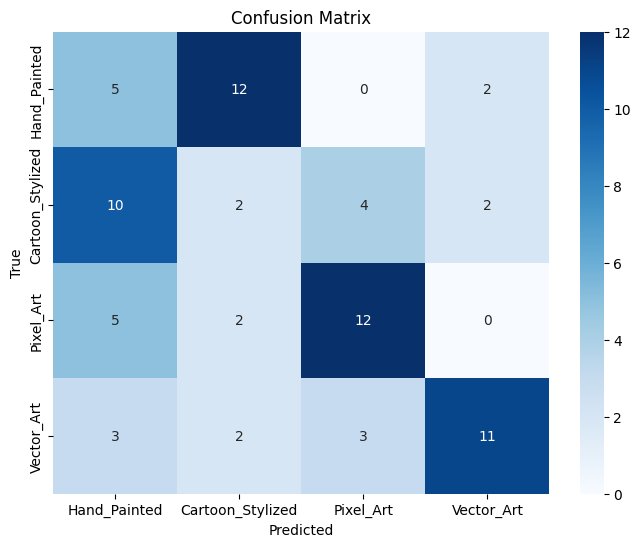

✅ Confusion matrix saved to /content/runs/classify/val/confusion_matrix.png


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from pathlib import Path

# --- CONFIG ---
class_names = ["Hand_Painted", "Cartoon_Stylized", "Pixel_Art", "Vector_Art"]  # actual classes
save_dir = Path("/content/runs/classify/val")
save_dir.mkdir(parents=True, exist_ok=True)
save_path = save_dir / "confusion_matrix.png"

# --- Compute confusion matrix ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

# --- Create figure ---
plt.figure(figsize=(8, 6))

# Plot using seaborn heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Save to file
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print(f"✅ Confusion matrix saved to {save_path}")

In [4]:
from pathlib import Path
from ultralytics import YOLO
import numpy as np

val_dir = "/content/asset_styles_yolo/val"
class_names = ["Hand_Painted", "Cartoon_Stylized", "Pixel_Art", "Vector_Art"]

model = YOLO("/content/runs/classify/train/weights/best.pt")

y_true = []
y_pred = []

for label_idx, class_name in enumerate(class_names):
    class_folder = Path(val_dir) / class_name
    if not class_folder.exists():
        continue
    for img_path in class_folder.iterdir():
        if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"]:
            continue
        results = model.predict(source=str(img_path), save=False, verbose=False)
        pred_class = results[0].probs.top1  # Top-1 predicted class index
        y_true.append(label_idx)
        y_pred.append(pred_class)

# --- Filter out predictions of extra "Styles" class if using nc=5 ---
y_true_filtered = []
y_pred_filtered = []
for t, p in zip(y_true, y_pred):
    if p < len(class_names):  # Only keep 0-3
        y_true_filtered.append(t)
        y_pred_filtered.append(p)

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# --- Compute Top-1 Accuracy manually ---
top1_accuracy = np.mean(np.array(y_true_filtered) == np.array(y_pred_filtered))

metrics_dict = {
    "Top-1 Accuracy": top1_accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

# Save to CSV
save_path = "/content/classification_metrics.csv"
pd.DataFrame([metrics_dict]).to_csv(save_path, index=False)
print(f"✅ Classification metrics successfully saved to: {save_path}")

✅ Classification metrics successfully saved to: /content/classification_metrics.csv


In [6]:
# test
from ultralytics import YOLO
from PIL import Image

# Load your trained model (use the best weights)
model = YOLO("/content/runs/classify/train/weights/best.pt")

# Path to your test image
test_image = "/content/Styles_unzipped/Styles/Pixel Art/Characters/pixel_char_06.png"
# Run prediction
results = model.predict(source=test_image, show=True)

# Print predicted class
print("Predicted class:", results[0].names[results[0].probs.top1])
print("Confidence:", results[0].probs.top1conf)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/Styles_unzipped/Styles/Pixel Art/Characters/pixel_char_06.png: 224x224 Pixel_Art 0.96, Vector_Art 0.04, Hand_Painted 0.00, Cartoon_Stylized 0.00, 26.3ms
Speed: 10.7ms preprocess, 26.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
Predicted class: Pixel_Art
Confidence: tensor(0.9574)


In [7]:
from ultralytics import YOLO
from pathlib import Path

# Load trained model
model = YOLO("/content/runs/classify/train/weights/best.pt")

# Path to test image
test_image = "/content/Styles_unzipped/Styles/Pixel Art/Characters/pixel_char_06.png"

# Run prediction
results = model.predict(source=test_image, verbose=False)

# Get top-1 predicted index and confidence
top1_idx = results[0].probs.top1
top1_conf = results[0].probs.top1conf

# Map index to class name
# Filter out the 5th class if it exists
class_names = ["Hand_Painted", "Cartoon_Stylized", "Pixel_Art", "Vector_Art"]
if top1_idx >= len(class_names):
    predicted_class = "Unknown / Extra Class"
else:
    predicted_class = class_names[top1_idx]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {top1_conf:.4f}")

Predicted class: Pixel_Art
Confidence: 0.9574


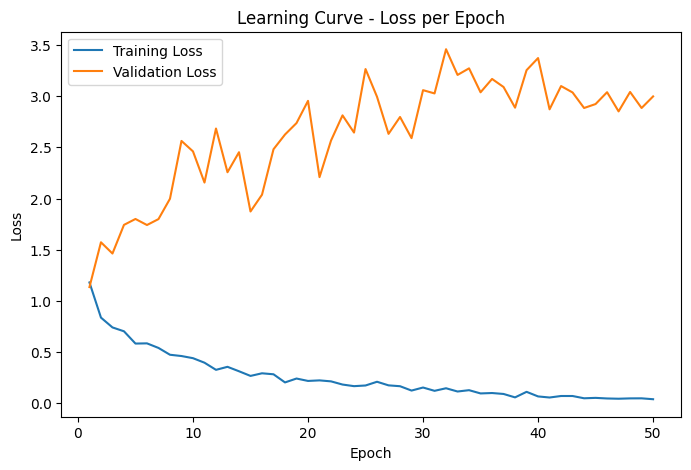

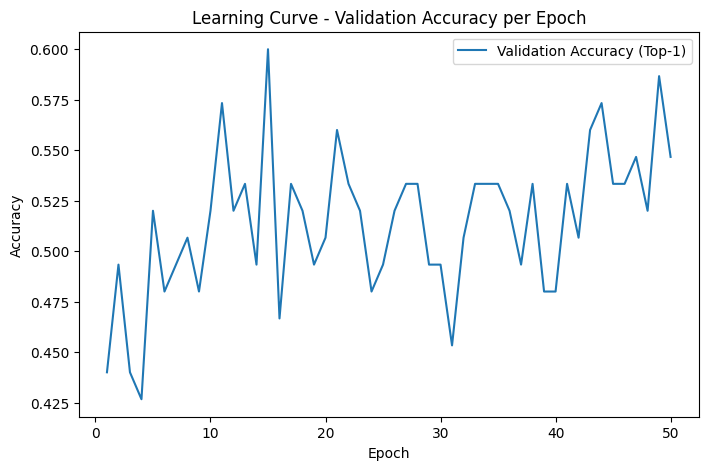

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to YOLO results
results_path = "/content/runs/classify/train/results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Plot training vs validation loss
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["train/loss"], label="Training Loss")
plt.plot(df["epoch"], df["val/loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve - Loss per Epoch")
plt.legend()
plt.show()

# Plot accuracy (Top-1)
plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["metrics/accuracy_top1"], label="Validation Accuracy (Top-1)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Validation Accuracy per Epoch")
plt.legend()
plt.show()

In [9]:
import pandas as pd

# Load your YOLO training log
df = pd.read_csv("/content/runs/classify/train/results.csv")

# Display the first few rows
print(df.head())

   epoch     time  train/loss  metrics/accuracy_top1  metrics/accuracy_top5  \
0      1  134.232     1.17969                0.44000                      1   
1      2  264.544     0.83614                0.49333                      1   
2      3  396.483     0.74028                0.44000                      1   
3      4  526.704     0.70237                0.42667                      1   
4      5  659.370     0.58247                0.52000                      1   

   val/loss    lr/pg0    lr/pg1    lr/pg2  
0   1.13451  0.000414  0.000414  0.000414  
1   1.57235  0.000814  0.000814  0.000814  
2   1.46244  0.001198  0.001198  0.001198  
3   1.74234  0.001176  0.001176  0.001176  
4   1.80006  0.001151  0.001151  0.001151  
